In [2]:
!conda install -c conda-forge dockstring -y

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /home/alxfgh/CodingProjects/BODock/.conda

  added / updated specs:
    - dockstring


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-1.74.0               |  py310h7c3ba0c_5         375 KB  conda-forge
    boost-cpp-1.74.0           |       h75c5d50_8        16.2 MB  conda-forge
    brotli-1.1.0               |       hd590300_1          19 KB  conda-forge
    brotli-bin-1.1.0           |       hd590300_1          19 KB  conda-forge
    cairo-1.16.0               |       hb05425b_5         1.2 MB
    certifi-2024.2.2           |     pyhd8ed1ab_0         157 KB  conda-forge
    cycler-0.12.1              |     pyhd8ed1ab_0          13 KB  conda-forge
    dockstring-0.3.2           |     pyhd8ed1ab_0         3.1 MB  conda-forge
    expat-2.6.2                

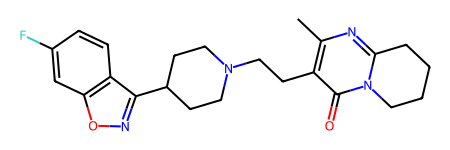

In [3]:
import rdkit.Chem as Chem

smiles = 'CC1=C(C(=O)N2CCCCC2=N1)CCN3CCC(CC3)C4=NOC5=C4C=CC(=C5)F'
Chem.MolFromSmiles(smiles)

In [4]:

from dockstring import load_target

target = load_target('DRD2')
score, aux = target.dock(smiles)

In [7]:
!pip3 install ax-platform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 23.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 24.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 22.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 22.5 MB/s eta 0:00:00


In [6]:
aux


{'ligand': <rdkit.Chem.rdchem.Mol at 0x7d4167836520>,
 'affinities': [-11.9, -11.8, -11.6, -11.1, -11.1, -11.0, -10.6, -10.4, -10.3]}

In [8]:
import dockstring
import ax
from ax import RangeParameter, ChoiceParameter, FixedParameter
from ax.modelbridge.factory import Models
from ax.utils.measurement_data import MeasurementData
from rdkit import Chem
from rdkit.Chem import Draw

# Set up the target and initial ligand
target = dockstring.protein.load_pdb("1hsg")
initial_ligand = dockstring.utils.smiles_to_mol("c1ccccc1C(=O)Nc2ccccc2")

# Define the search space
search_space = [
    RangeParameter(
        name='mutation_rate',
        parameter_type='float',
        lower=0.0,
        upper=1.0
    ),
    ChoiceParameter(
        name='mutation_type',
        parameter_type='str',
        values=['insert', 'remove', 'replace']
    )
]

# Define the objective function
def objective_function(parameterization):
    mutation_rate = parameterization.get('mutation_rate')
    mutation_type = parameterization.get('mutation_type')

    # Apply mutations to the initial ligand
    mutated_mol = dockstring.utils.mutate_molecule(
        initial_ligand, mutation_rate, mutation_type
    )

    # Dock the mutated molecule
    docked_mol = dockstring.dock.dock(mutated_mol, target)

    # Score the docked molecule
    binding_score = dockstring.score.dockstring_scorer(docked_mol, target)

    return binding_score

# Create an Ax experiment
exp = ax.SimpleExperiment(
    name='docking_optimization',
    search_space=search_space,
    evaluation_function=objective_function,
    objective_name='binding_score',
    minimize=False,
    model=Models.SOBOL,
)

# Run the optimization loop
for _ in range(100):
    parameterization, idx = exp.get_next_trial()
    exp.eval_and_store(parameterization, idx, objective_function(parameterization))

# Get the best parameterization
best_parameterization, best_binding_score = exp.get_best_objective_and_parameters()
print(f"Best parameterization: {best_parameterization}")
print(f"Best binding score: {best_binding_score}")

# Visualize the best molecule
best_mol = dockstring.utils.mutate_molecule(
    initial_ligand,
    best_parameterization.get('mutation_rate'),
    best_parameterization.get('mutation_type')
)
Draw.MolToFile(best_mol, 'best_molecule.png')

/home/alxfgh/CodingProjects/BODock/.conda/lib/python3.10/site-packages/botorch/utils/sampling.py:24: UserWarning: A NumPy version >=1.22.4 and <1.29.0 is required for this version of SciPy (detected version 1.22.3)
  import scipy


AttributeError: module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'

In [11]:
from rdkit import Chem
from rdkit.Chem import Draw
from dockstring import load_target
import random

# Load the target protein
target = load_target('DRD2')

# Define the initial ligand
initial_ligand = Chem.MolFromSmiles("c1ccccc1C(=O)Nc2ccccc2")

# Define the search space
search_space = [
    RangeParameter(
        name='mutation_rate',
        parameter_type='float',
        lower=0.0,
        upper=1.0
    ),
    ChoiceParameter(
        name='mutation_type',
        parameter_type='str',
        values=['insert', 'remove', 'replace']
    )
]

# Define the objective function
def objective_function(parameterization):
    mutation_rate = parameterization.get('mutation_rate')
    mutation_type = parameterization.get('mutation_type')

    # Apply mutations to the initial ligand
    mutated_mol = mutate_molecule(initial_ligand, mutation_rate, mutation_type)

    # Score the mutated molecule using dockstring
    score, _ = target.dock(Chem.MolToSmiles(mutated_mol))

    return score

# Function to mutate a molecule
def mutate_molecule(mol, mutation_rate, mutation_type):
    # Implement your mutation logic here
    return mutated_mol

# Create an Ax experiment
exp = ax.SimpleExperiment(
    name='docking_optimization',
    search_space=search_space,
    evaluation_function=objective_function,
    objective_name='binding_score',
    minimize=False,
    model=Models.SOBOL,
)

# Run the optimization loop
for _ in range(100):
    parameterization, idx = exp.get_next_trial()
    exp.eval_and_store(parameterization, idx, objective_function(parameterization))

# Get the best parameterization
best_parameterization, best_binding_score = exp.get_best_objective_and_parameters()
print(f"Best parameterization: {best_parameterization}")
print(f"Best binding score: {best_binding_score}")

# Visualize the best molecule
best_mol = mutate_molecule(
    initial_ligand,
    best_parameterization.get('mutation_rate'),
    best_parameterization.get('mutation_type')
)
Draw.MolToFile(best_mol, 'best_molecule.png')

NameError: name 'RangeParameter' is not defined

In [12]:
from rdkit import Chem
from rdkit.Chem import Draw
from dockstring import load_target
import random

# Assuming mutate_molecule is correctly defined elsewhere
# from your_mutation_logic import mutate_molecule

# Importing necessary components from Ax
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import render

# Load the target protein
target = load_target('DRD2')

# Define the initial ligand
initial_ligand = Chem.MolFromSmiles("c1ccccc1C(=O)Nc2ccccc2")

# Initialize AxClient and create an experiment
ax_client = AxClient()
ax_client.create_experiment(
    name="docking_optimization",
    parameters=[
        {"name": "mutation_rate", "type": "range", "bounds": [0.0, 1.0], "value_type": "float"},
        {"name": "mutation_type", "type": "choice", "values": ["insert", "remove", "replace"], "value_type": "str"},
    ],
    objectives={"binding_score": "maximize"},
)

# Define the objective function
def objective_function(parameterization):
    mutation_rate = parameterization.get('mutation_rate')
    mutation_type = parameterization.get('mutation_type')

    # Apply mutations to the initial ligand
    mutated_mol = mutate_molecule(initial_ligand, mutation_rate, mutation_type)

    # Score the mutated molecule using dockstring
    score, _ = target.dock(Chem.MolToSmiles(mutated_mol))

    return {"binding_score": (score, 0.0)}  # Assuming score is a float. The 0.0 is the SEM (standard error of the mean).

# Run the optimization loop
for _ in range(25):  # Adjust the number of iterations as needed
    parameters, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(trial_index=trial_index, raw_data=objective_function(parameters))

# Extract the best parameters and score
best_parameters, metrics = ax_client.get_best_parameters()
best_score = metrics["binding_score"]

print(f"Best parameters: {best_parameters}")
print(f"Best binding score: {best_score}")

# Visualize the best molecule
best_mol = mutate_molecule(
    initial_ligand,
    best_parameters['mutation_rate'],
    best_parameters['mutation_type']
)
Draw.MolToFile(best_mol, 'best_molecule.png')


AttributeError: module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'